# GAT-GRU

This notebook presents the data preprocessing, training, and result metrics for the GAT-GRU architecture on traffic forecasting. Two datasets, PEMS04 and PEMS08 are used, as well as 2 time horizons, 15 and 60 minutes. 

The model is run 3 times on each dataset-horizon combination, using seeds 0, 42, and 1337.

See the project report for more details.

In [1]:
%%capture
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [2]:
import numpy as np
import csv
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as pyg
from torch.optim import Adam
from torch_geometric.data import Batch, Data
from torch_geometric.nn.conv import GATConv

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

The dataset is a long sequence of graphs, so it needs to be split into smaller sequences to fit the desired time window. The model will use *n* traffic graphs to predict the next *n* traffic graphs, so inputs and targets are always consecutive sequences.

In [4]:
def input_target_split(data, seq_len):
    inputs = []
    targets = []
    for t in range(0, len(data) - seq_len * 2, np.ceil(seq_len / 2).astype(int)):
        inputs.append(torch.tensor(data[t:t + seq_len], dtype=torch.float))
        targets.append(torch.tensor(data[t + seq_len:t + seq_len * 2], dtype=torch.float))
    return inputs, targets

Here we do an 0.8/0.1/0.1 train-validation-test split. We normalize the data using only the statistics (mean and std) of the training data, to avoid leaking information about the validation and test datasets.

In [5]:
def split_and_norm(input_data, target_data, train_ratio=0.8, val_ratio=0.1):
    inputs = torch.stack(input_data)
    targets = torch.stack(target_data)

    train_inputs, temp_inputs, train_targets, temp_targets = train_test_split(
        inputs, targets, test_size=(1 - train_ratio)
    )
    val_inputs, test_inputs, val_targets, test_targets = train_test_split(
        temp_inputs, temp_targets, test_size=(1 - train_ratio - val_ratio)
    )

    train_data = torch.cat([train_inputs, train_targets], dim=0)
    train_mean = train_data.mean(dim=(0, 1), keepdim=True)
    train_std = train_data.std(dim=(0, 1), keepdim=True)

    def normalize(data, mean, std):
        return (data - mean) / std
    
    train_inputs = normalize(train_inputs, train_mean, train_std)
    val_inputs = normalize(val_inputs, train_mean, train_std)
    test_inputs = normalize(test_inputs, train_mean, train_std)
    
    train_targets = normalize(train_targets, train_mean, train_std)
    val_targets = normalize(val_targets, train_mean, train_std)
    test_targets = normalize(test_targets, train_mean, train_std)

    return train_mean, train_std, train_inputs, train_targets, val_inputs, val_targets, test_inputs, test_targets


Load the dataset; initalize the edge index and edge attributes.

In [6]:
def load_data(dataset_name, dir, seed, steps):
    pyg.seed_everything(seed)
    
    npz_path = f"{dir}/{dataset_name}.npz"
    csv_path = f"{dir}/{dataset_name}.csv"
    
    with np.load(npz_path) as f:
        original_data = f['data']
    
    with open(csv_path, 'r') as f:
        reader = csv.reader(f)
        edges = list(reader)
    
    df = pd.DataFrame(edges[1:], columns=edges[0])
    df['from'] = df['from'].astype(int)
    df['to'] = df['to'].astype(int)
    df['cost'] = df['cost'].astype(float)
    
    edge_index = torch.tensor(df[['from', 'to']].values.T, dtype=torch.long)
    edge_attr = torch.tensor(df['cost'].values, dtype=torch.float)

    inputs, targets = input_target_split(original_data, seq_len=steps)
    return edge_index, edge_attr, *split_and_norm(inputs, targets)

This defines the GAT-GRU model, which uses a combination of a GAT (with regularization through dropout and skip connection) and a GRU. The comments show how the tensor shape changes throughout the forward method.

In [7]:
class GAT_GRU_Model(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_gru_layers=1, dropout=0.2):
        super(GAT_GRU_Model, self).__init__()
        self.gat = GATConv(in_channels, hidden_channels, dropout=dropout)
        self.skip_proj = nn.Linear(in_channels, hidden_channels)
        self.dropout = nn.Dropout(dropout)
        self.gru = nn.GRU(hidden_channels, hidden_channels, num_layers=num_gru_layers, batch_first=False)
        self.fc = nn.Linear(hidden_channels, in_channels)

    def forward(self, inputs, edge_index, edge_attr, hidden_state=None):
        # (seq_len, batches, nodes, hidden_channels)
        seq_len = inputs.size(0)
        n_batch = inputs.size(1)
        n_nodes = inputs.size(2)

        seq_embeddings = []
        for seq in inputs:
            # (batches, nodes, hidden_channels)
            batch = Batch.from_data_list([
                Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
                for x in seq
            ])
            # (batches * nodes, hidden_channels) -> (batches * nodes, hidden_channels)
            node_embeddings = self.gat(batch.x, batch.edge_index, batch.edge_attr)
            skip_output = self.skip_proj(batch.x)
            node_embeddings = F.relu(node_embeddings + skip_output) # skip connection
            seq_embeddings.append(node_embeddings)

        # (seq_len, batches * nodes, hidden_channels)
        embeddings_output = torch.stack(seq_embeddings, dim=0)
        embeddings_output = self.dropout(embeddings_output)

        # (seq_len, batches * nodes, hidden_channels) -> (seq_len, batches * nodes, hidden_channels)
        gru_output, hidden_state = self.gru(embeddings_output, hidden_state)

        # (seq_len, batches * nodes, hidden_channels) -> (seq_len, batches, nodes, hidden_channels)
        output = gru_output.view((seq_len, n_batch, n_nodes, -1))

        # (seq_len, batches, nodes, hidden_channels) -> (seq_len, batches, nodes, out_channels)
        output = self.fc(output)
        return output, hidden_state

This runs the model on a single minibatch of the data. It first processes the entire input sequence, then generates the predictions one by one. This is to facilitate teacher forcing. The loss at each step is computed and the average is returned.

In [8]:
def model_run(model, input_data, target_data, teacher_forcing_ratio=0.5):
    loss = 0
    output, hidden_state = model(input_data.to(device), edge_index, edge_attr, hidden_state=None)
    for i in range(len(target_data)):
        if i == 0:
            current_data = input_data[-1].unsqueeze(0)
        elif torch.rand(1).item() < teacher_forcing_ratio:
            current_data = target_data[i - 1].unsqueeze(0)
        else:
            current_data = output
        output, hidden_state = model(current_data.to(device), edge_index, edge_attr, hidden_state)
        current_data = output.to("cpu")
        loss += F.mse_loss(current_data.squeeze(0), target_data[i])
    return loss / len(target_data)

This trains the model over all epochs. After each epoch, validation loss is computed. At the end, the model weights of the version that achieved the best validation loss are selected. It also plots the training and validation loss curves.

In [9]:
def train(data, dataset_name, seed, steps, epochs, batch_size, lr=1e-3, teacher_forcing_ratio=0.5):
    train_inputs, train_targets, val_inputs, val_targets, test_inputs, test_targets = data
    
    id = f'best_model_{dataset_name}_{epochs}epoch_{steps}step_{seed}seed'
    save_path = id + '.sav'

    n_features = train_inputs[0].size(-1)
    model = GAT_GRU_Model(in_channels=n_features, hidden_channels=16).to(device)
    optimizer = Adam(model.parameters(), lr=lr)
    print(f"save path: {save_path}")

    best_val_loss = float('inf')
    train_losses = np.zeros(epochs)
    val_losses = np.zeros(epochs)
    for epoch in range(epochs):
        train_loss = 0
        iters = 0
        for i in range(0, len(train_inputs), batch_size):
            iters += 1
            input_data = train_inputs[i:i+batch_size].permute(1, 0, 2, 3)
            target_data = train_targets[i:i+batch_size].permute(1, 0, 2, 3)
            model.train()
            optimizer.zero_grad()
            loss = model_run(model, input_data, target_data, teacher_forcing_ratio)
            loss.backward()
            train_loss += loss.item()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        train_loss /= iters
        train_losses[epoch] = train_loss
    
        with torch.no_grad():
            model.eval()
            val_loss = 0
            iters = 0
            for i in range(0, len(val_inputs), batch_size):
                iters += 1
                input_data = val_inputs[i:i+batch_size].permute(1, 0, 2, 3)
                target_data = val_targets[i:i+batch_size].permute(1, 0, 2, 3)
                val_loss += model_run(model, input_data, target_data, teacher_forcing_ratio=0).item()
            val_loss /= iters
            val_losses[epoch] = val_loss
        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), save_path)
    
    with torch.no_grad():
        model.eval()
        test_loss = 0
        iters = 0
        for i in range(0, len(test_inputs), batch_size):
            iters += 1
            input_data = test_inputs[i:i+batch_size].permute(1, 0, 2, 3)
            target_data = test_targets[i:i+batch_size].permute(1, 0, 2, 3)
            test_loss += model_run(model, input_data, target_data, teacher_forcing_ratio=0).item()
        test_loss /= iters
    print(f"Test Loss: {test_loss:.4f}")

    epoch_range = range(0, epochs)
    plt.plot(epoch_range, train_losses, label='Training Loss')
    plt.plot(epoch_range, val_losses, label='Validation Loss')
     
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    
    plt.xticks(range(0, epochs, 5))
    
    plt.legend(loc='best')
    plt.savefig(id+'.png')
    plt.show()

    return model, save_path
    

This evaluates the model by computing its MAE and RMSE statistics on the test data. The prediction and target data are denormalized before the metrics are computed.

In [10]:
def evaluate(model, save_path, test_inputs, test_targets, batch_size, edge_index, edge_attr, mean, std):
    model.load_state_dict(torch.load(save_path))

    def denormalize(data):
        return data * std + mean
    
    with torch.no_grad():
        model.eval()
        mae_loss = 0
        mse_loss = 0
        total_elems = 0
        for i in range(0, len(test_inputs), batch_size):
            input_data = test_inputs[i:i+batch_size].permute(1, 0, 2, 3)
            target_data = test_targets[i:i+batch_size].permute(1, 0, 2, 3)
            
            output, hidden_state = model(input_data.to(device), edge_index, edge_attr, hidden_state=None)
            preds = []
            for i in range(len(target_data)):
                if i == 0:
                    current_data = input_data[-1].unsqueeze(0)
                else:
                    current_data = output
                output, hidden_state = model(current_data.to(device), edge_index, edge_attr, hidden_state)
                preds.append(output.squeeze(0).to("cpu"))
            pred_tensor = torch.tensor(np.array([denormalize(p) for p in preds]))
            target_tensor = torch.tensor(np.array([denormalize(t) for t in target_data]))
            mae_loss += F.l1_loss(pred_tensor, target_tensor, reduction="sum")
            mse_loss += F.mse_loss(pred_tensor, target_tensor, reduction="sum")
            total_elems += pred_tensor.numel()
        mae_loss /= total_elems
        mse_loss /= total_elems   
        rmse_loss = torch.sqrt(mse_loss)
    print(f"MAE Loss: {mae_loss.item()}")
    print(f"MSE Loss: {mse_loss.item()}")
    print(f"RMSE Loss: {rmse_loss.item()}")

# PEMS04

Here we run the model on PEMS04, with 50 epochs and a batch size of 256. This will be done on both 60m and 15m time windows, with seeds 0, 42, and 1337.

In [11]:
epochs = 50
batch_size = 256
dataset_name = "PEMS04"
dir = "/kaggle/input/pems-dataset/data/PEMS04"

## 12 steps (60 m)

In [12]:
steps = 12

### Seed 0

In [13]:
seed = 0
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)

In [14]:
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS04_50epoch_12step_0seed.sav


/opt/conda/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Train Loss: 0.9939, Val Loss: 0.9905
Epoch 1, Train Loss: 0.8803, Val Loss: 0.9327
Epoch 2, Train Loss: 0.7599, Val Loss: 0.8589
Epoch 3, Train Loss: 0.6515, Val Loss: 0.7307
Epoch 4, Train Loss: 0.4940, Val Loss: 0.5280
Epoch 5, Train Loss: 0.3900, Val Loss: 0.4330
Epoch 6, Train Loss: 0.3511, Val Loss: 0.4284
Epoch 7, Train Loss: 0.3221, Val Loss: 0.4127
Epoch 8, Train Loss: 0.3257, Val Loss: 0.4046
Epoch 9, Train Loss: 0.3176, Val Loss: 0.3963
Epoch 10, Train Loss: 0.2980, Val Loss: 0.3898
Epoch 11, Train Loss: 0.2879, Val Loss: 0.3838
Epoch 12, Train Loss: 0.2838, Val Loss: 0.3805
Epoch 13, Train Loss: 0.2639, Val Loss: 0.3778
Epoch 14, Train Loss: 0.2639, Val Loss: 0.3751
Epoch 15, Train Loss: 0.2616, Val Loss: 0.3685
Epoch 16, Train Loss: 0.2716, Val Loss: 0.3613
Epoch 17, Train Loss: 0.2573, Val Loss: 0.3557
Epoch 18, Train Loss: 0.2465, Val Loss: 0.3523
Epoch 19, Train Loss: 0.2529, Val Loss: 0.3464
Epoch 20, Train Loss: 0.2436, Val Loss: 0.3412
Epoch 21, Train Loss: 0

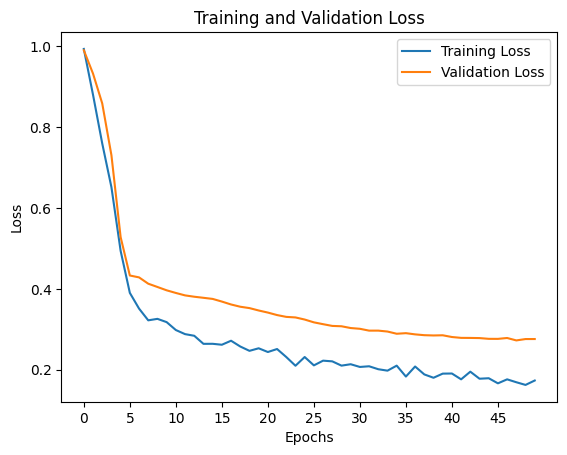

In [15]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [16]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 11.680092811584473
MSE Loss: 800.9954223632812
RMSE Loss: 28.301862716674805


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


### Seed 42

In [17]:
seed = 42
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)

In [18]:
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS04_50epoch_12step_42seed.sav
Epoch 0, Train Loss: 0.8393, Val Loss: 0.8412
Epoch 1, Train Loss: 0.7279, Val Loss: 0.7114
Epoch 2, Train Loss: 0.6213, Val Loss: 0.6106
Epoch 3, Train Loss: 0.4997, Val Loss: 0.5514
Epoch 4, Train Loss: 0.4360, Val Loss: 0.5199
Epoch 5, Train Loss: 0.4037, Val Loss: 0.4914
Epoch 6, Train Loss: 0.3739, Val Loss: 0.4578
Epoch 7, Train Loss: 0.3566, Val Loss: 0.4386
Epoch 8, Train Loss: 0.3441, Val Loss: 0.4228
Epoch 9, Train Loss: 0.3295, Val Loss: 0.4064
Epoch 10, Train Loss: 0.3074, Val Loss: 0.3912
Epoch 11, Train Loss: 0.2933, Val Loss: 0.3825
Epoch 12, Train Loss: 0.2864, Val Loss: 0.3724
Epoch 13, Train Loss: 0.2688, Val Loss: 0.3660
Epoch 14, Train Loss: 0.2628, Val Loss: 0.3621
Epoch 15, Train Loss: 0.2548, Val Loss: 0.3580
Epoch 16, Train Loss: 0.2450, Val Loss: 0.3554
Epoch 17, Train Loss: 0.2493, Val Loss: 0.3501
Epoch 18, Train Loss: 0.2266, Val Loss: 0.3483
Epoch 19, Train Loss: 0.2248, Val Loss: 0.3460
Epoch 20, Train

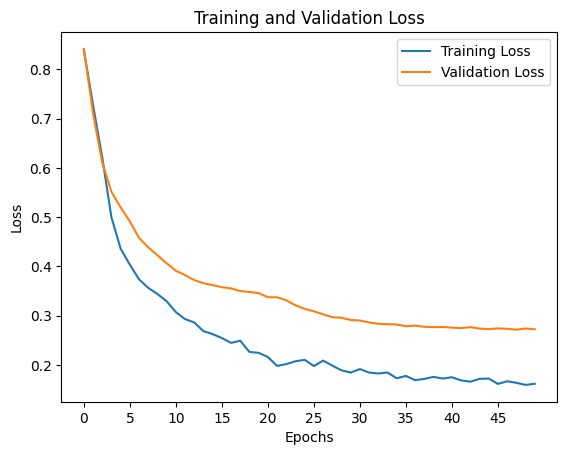

In [19]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [20]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 12.422584533691406
MSE Loss: 809.0315551757812
RMSE Loss: 28.443479537963867


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


### Seed 1337

In [21]:
seed = 1337
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS04_50epoch_12step_1337seed.sav
Epoch 0, Train Loss: 1.0186, Val Loss: 1.0314
Epoch 1, Train Loss: 0.9165, Val Loss: 0.9639
Epoch 2, Train Loss: 0.7914, Val Loss: 0.8790
Epoch 3, Train Loss: 0.6556, Val Loss: 0.7391
Epoch 4, Train Loss: 0.5156, Val Loss: 0.5688
Epoch 5, Train Loss: 0.4248, Val Loss: 0.4869
Epoch 6, Train Loss: 0.3786, Val Loss: 0.5005
Epoch 7, Train Loss: 0.3648, Val Loss: 0.4764
Epoch 8, Train Loss: 0.3483, Val Loss: 0.4339
Epoch 9, Train Loss: 0.3198, Val Loss: 0.4061
Epoch 10, Train Loss: 0.3107, Val Loss: 0.3928
Epoch 11, Train Loss: 0.2862, Val Loss: 0.3880
Epoch 12, Train Loss: 0.2649, Val Loss: 0.3839
Epoch 13, Train Loss: 0.2642, Val Loss: 0.3790
Epoch 14, Train Loss: 0.2590, Val Loss: 0.3771
Epoch 15, Train Loss: 0.2494, Val Loss: 0.3741
Epoch 16, Train Loss: 0.2367, Val Loss: 0.3698
Epoch 17, Train Loss: 0.2399, Val Loss: 0.3672
Epoch 18, Train Loss: 0.2415, Val Loss: 0.3563
Epoch 19, Train Loss: 0.2234, Val Loss: 0.3571
Epoch 20, Tra

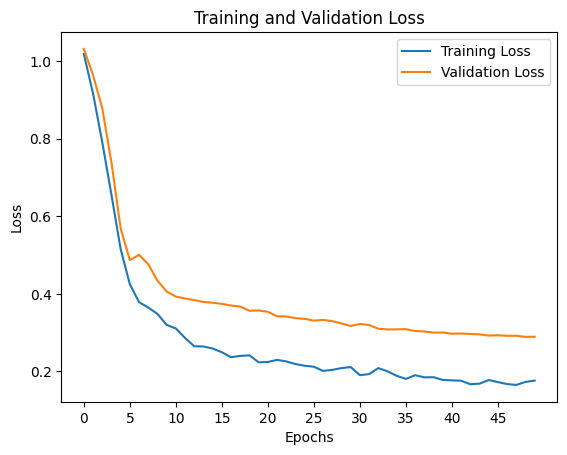

In [22]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [23]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 12.082180976867676
MSE Loss: 810.023193359375
RMSE Loss: 28.460906982421875


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


## 3 steps (15 m)

We do the same as the above, but with a 15 minute time window instead.

In [24]:
steps = 3

### Seed 0

In [25]:
seed = 0
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS04_50epoch_3step_0seed.sav
Epoch 0, Train Loss: 0.8639, Val Loss: 0.6798
Epoch 1, Train Loss: 0.5012, Val Loss: 0.3417
Epoch 2, Train Loss: 0.3133, Val Loss: 0.2729
Epoch 3, Train Loss: 0.2699, Val Loss: 0.2484
Epoch 4, Train Loss: 0.2472, Val Loss: 0.2298
Epoch 5, Train Loss: 0.2272, Val Loss: 0.2150
Epoch 6, Train Loss: 0.2169, Val Loss: 0.2022
Epoch 7, Train Loss: 0.2031, Val Loss: 0.1912
Epoch 8, Train Loss: 0.1906, Val Loss: 0.1819
Epoch 9, Train Loss: 0.1813, Val Loss: 0.1741
Epoch 10, Train Loss: 0.1750, Val Loss: 0.1678
Epoch 11, Train Loss: 0.1698, Val Loss: 0.1629
Epoch 12, Train Loss: 0.1630, Val Loss: 0.1588
Epoch 13, Train Loss: 0.1598, Val Loss: 0.1552
Epoch 14, Train Loss: 0.1539, Val Loss: 0.1523
Epoch 15, Train Loss: 0.1549, Val Loss: 0.1498
Epoch 16, Train Loss: 0.1529, Val Loss: 0.1476
Epoch 17, Train Loss: 0.1462, Val Loss: 0.1455
Epoch 18, Train Loss: 0.1472, Val Loss: 0.1439
Epoch 19, Train Loss: 0.1430, Val Loss: 0.1425
Epoch 20, Train L

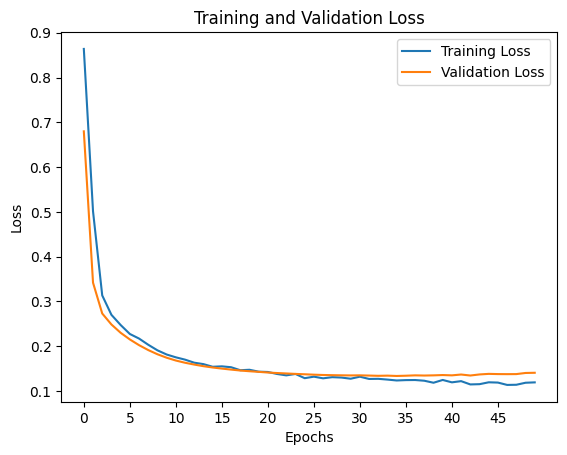

In [26]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [27]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


MAE Loss: 8.336238861083984
MSE Loss: 436.746337890625
RMSE Loss: 20.89847755432129


### Seed 42

In [28]:
seed = 42
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS04_50epoch_3step_42seed.sav
Epoch 0, Train Loss: 0.7110, Val Loss: 0.5427
Epoch 1, Train Loss: 0.4307, Val Loss: 0.3633
Epoch 2, Train Loss: 0.3273, Val Loss: 0.3041
Epoch 3, Train Loss: 0.2854, Val Loss: 0.2608
Epoch 4, Train Loss: 0.2425, Val Loss: 0.2289
Epoch 5, Train Loss: 0.2135, Val Loss: 0.2079
Epoch 6, Train Loss: 0.1974, Val Loss: 0.1936
Epoch 7, Train Loss: 0.1891, Val Loss: 0.1826
Epoch 8, Train Loss: 0.1802, Val Loss: 0.1735
Epoch 9, Train Loss: 0.1669, Val Loss: 0.1662
Epoch 10, Train Loss: 0.1680, Val Loss: 0.1603
Epoch 11, Train Loss: 0.1615, Val Loss: 0.1557
Epoch 12, Train Loss: 0.1573, Val Loss: 0.1520
Epoch 13, Train Loss: 0.1530, Val Loss: 0.1491
Epoch 14, Train Loss: 0.1510, Val Loss: 0.1468
Epoch 15, Train Loss: 0.1477, Val Loss: 0.1446
Epoch 16, Train Loss: 0.1418, Val Loss: 0.1428
Epoch 17, Train Loss: 0.1424, Val Loss: 0.1411
Epoch 18, Train Loss: 0.1383, Val Loss: 0.1396
Epoch 19, Train Loss: 0.1360, Val Loss: 0.1388
Epoch 20, Train 

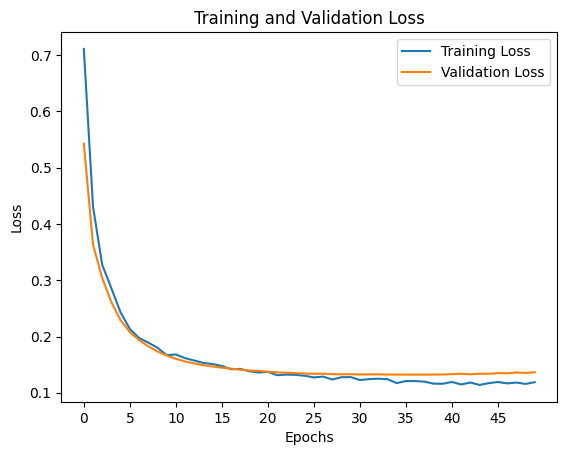

In [29]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [30]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 8.699349403381348
MSE Loss: 430.56939697265625
RMSE Loss: 20.750165939331055


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


### Seed 1337

In [31]:
seed = 1337
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS04_50epoch_3step_1337seed.sav
Epoch 0, Train Loss: 0.8839, Val Loss: 0.7239
Epoch 1, Train Loss: 0.5301, Val Loss: 0.3736
Epoch 2, Train Loss: 0.3382, Val Loss: 0.2991
Epoch 3, Train Loss: 0.2753, Val Loss: 0.2436
Epoch 4, Train Loss: 0.2361, Val Loss: 0.2208
Epoch 5, Train Loss: 0.2159, Val Loss: 0.2084
Epoch 6, Train Loss: 0.2017, Val Loss: 0.1984
Epoch 7, Train Loss: 0.1883, Val Loss: 0.1901
Epoch 8, Train Loss: 0.1817, Val Loss: 0.1828
Epoch 9, Train Loss: 0.1791, Val Loss: 0.1765
Epoch 10, Train Loss: 0.1730, Val Loss: 0.1709
Epoch 11, Train Loss: 0.1653, Val Loss: 0.1661
Epoch 12, Train Loss: 0.1639, Val Loss: 0.1618
Epoch 13, Train Loss: 0.1628, Val Loss: 0.1581
Epoch 14, Train Loss: 0.1535, Val Loss: 0.1549
Epoch 15, Train Loss: 0.1535, Val Loss: 0.1521
Epoch 16, Train Loss: 0.1500, Val Loss: 0.1499
Epoch 17, Train Loss: 0.1488, Val Loss: 0.1477
Epoch 18, Train Loss: 0.1439, Val Loss: 0.1457
Epoch 19, Train Loss: 0.1447, Val Loss: 0.1440
Epoch 20, Trai

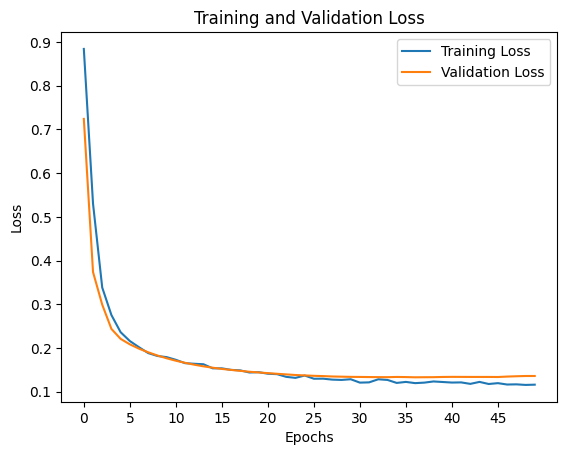

In [32]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [33]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 8.501151084899902
MSE Loss: 417.5257263183594
RMSE Loss: 20.433446884155273


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


---

# PEMS08

Here we do the same as we did for PEMS04, but for the PEMS08 dataset.

In [34]:
epochs = 50
batch_size = 256
dataset_name = "PEMS08"
dir = "/kaggle/input/pems-dataset/data/PEMS08"

## 12 steps (60 m)

In [35]:
steps = 12

### Seed 0

In [36]:
seed = 0
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS08_50epoch_12step_0seed.sav
Epoch 0, Train Loss: 0.9954, Val Loss: 0.9903
Epoch 1, Train Loss: 0.8686, Val Loss: 0.9276
Epoch 2, Train Loss: 0.7311, Val Loss: 0.8351
Epoch 3, Train Loss: 0.5936, Val Loss: 0.6534
Epoch 4, Train Loss: 0.4501, Val Loss: 0.4770
Epoch 5, Train Loss: 0.3794, Val Loss: 0.4556
Epoch 6, Train Loss: 0.3397, Val Loss: 0.4418
Epoch 7, Train Loss: 0.3468, Val Loss: 0.4338
Epoch 8, Train Loss: 0.3253, Val Loss: 0.4262
Epoch 9, Train Loss: 0.3097, Val Loss: 0.4191
Epoch 10, Train Loss: 0.3077, Val Loss: 0.4109
Epoch 11, Train Loss: 0.2861, Val Loss: 0.4082
Epoch 12, Train Loss: 0.2827, Val Loss: 0.4036
Epoch 13, Train Loss: 0.2791, Val Loss: 0.3947
Epoch 14, Train Loss: 0.2722, Val Loss: 0.3885
Epoch 15, Train Loss: 0.2638, Val Loss: 0.3827
Epoch 16, Train Loss: 0.2677, Val Loss: 0.3723
Epoch 17, Train Loss: 0.2546, Val Loss: 0.3635
Epoch 18, Train Loss: 0.2603, Val Loss: 0.3547
Epoch 19, Train Loss: 0.2492, Val Loss: 0.3460
Epoch 20, Train 

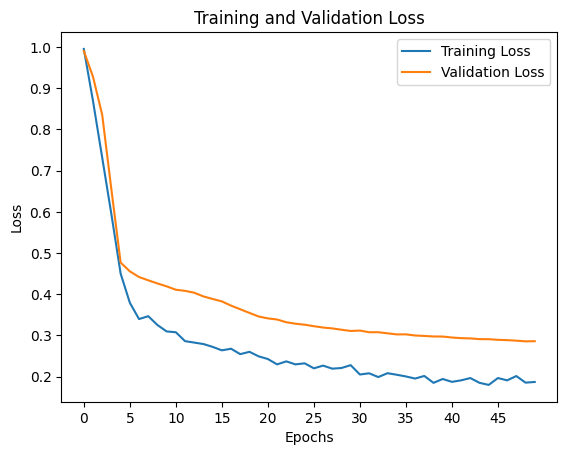

In [37]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [38]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 9.720015525817871
MSE Loss: 552.08203125
RMSE Loss: 23.49642562866211


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


### Seed 42

In [39]:
seed = 42
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS08_50epoch_12step_42seed.sav
Epoch 0, Train Loss: 0.8298, Val Loss: 0.9162
Epoch 1, Train Loss: 0.7089, Val Loss: 0.7448
Epoch 2, Train Loss: 0.5680, Val Loss: 0.6330
Epoch 3, Train Loss: 0.4670, Val Loss: 0.5666
Epoch 4, Train Loss: 0.4082, Val Loss: 0.5369
Epoch 5, Train Loss: 0.3828, Val Loss: 0.5049
Epoch 6, Train Loss: 0.3595, Val Loss: 0.4816
Epoch 7, Train Loss: 0.3399, Val Loss: 0.4596
Epoch 8, Train Loss: 0.3250, Val Loss: 0.4379
Epoch 9, Train Loss: 0.3075, Val Loss: 0.4195
Epoch 10, Train Loss: 0.2948, Val Loss: 0.4052
Epoch 11, Train Loss: 0.2779, Val Loss: 0.3937
Epoch 12, Train Loss: 0.2719, Val Loss: 0.3850
Epoch 13, Train Loss: 0.2648, Val Loss: 0.3773
Epoch 14, Train Loss: 0.2591, Val Loss: 0.3698
Epoch 15, Train Loss: 0.2503, Val Loss: 0.3588
Epoch 16, Train Loss: 0.2378, Val Loss: 0.3554
Epoch 17, Train Loss: 0.2300, Val Loss: 0.3460
Epoch 18, Train Loss: 0.2177, Val Loss: 0.3408
Epoch 19, Train Loss: 0.2176, Val Loss: 0.3323
Epoch 20, Train

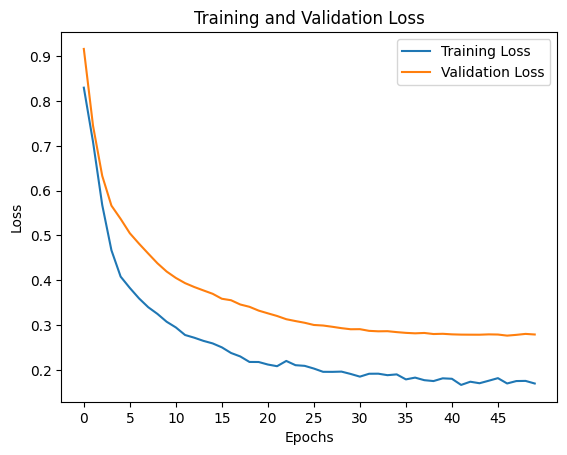

In [40]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [41]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 9.923822402954102
MSE Loss: 563.6094360351562
RMSE Loss: 23.740459442138672


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


### Seed 1337

In [42]:
seed = 1337
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS08_50epoch_12step_1337seed.sav
Epoch 0, Train Loss: 1.0066, Val Loss: 1.0476
Epoch 1, Train Loss: 0.8926, Val Loss: 0.9715
Epoch 2, Train Loss: 0.7427, Val Loss: 0.8605
Epoch 3, Train Loss: 0.5923, Val Loss: 0.6829
Epoch 4, Train Loss: 0.4701, Val Loss: 0.5372
Epoch 5, Train Loss: 0.3901, Val Loss: 0.5423
Epoch 6, Train Loss: 0.3771, Val Loss: 0.5396
Epoch 7, Train Loss: 0.3615, Val Loss: 0.5018
Epoch 8, Train Loss: 0.3377, Val Loss: 0.4786
Epoch 9, Train Loss: 0.3213, Val Loss: 0.4628
Epoch 10, Train Loss: 0.2951, Val Loss: 0.4518
Epoch 11, Train Loss: 0.2809, Val Loss: 0.4381
Epoch 12, Train Loss: 0.2688, Val Loss: 0.4328
Epoch 13, Train Loss: 0.2626, Val Loss: 0.4289
Epoch 14, Train Loss: 0.2392, Val Loss: 0.4261
Epoch 15, Train Loss: 0.2565, Val Loss: 0.4145
Epoch 16, Train Loss: 0.2365, Val Loss: 0.4100
Epoch 17, Train Loss: 0.2423, Val Loss: 0.4055
Epoch 18, Train Loss: 0.2380, Val Loss: 0.3984
Epoch 19, Train Loss: 0.2391, Val Loss: 0.3975
Epoch 20, Tra

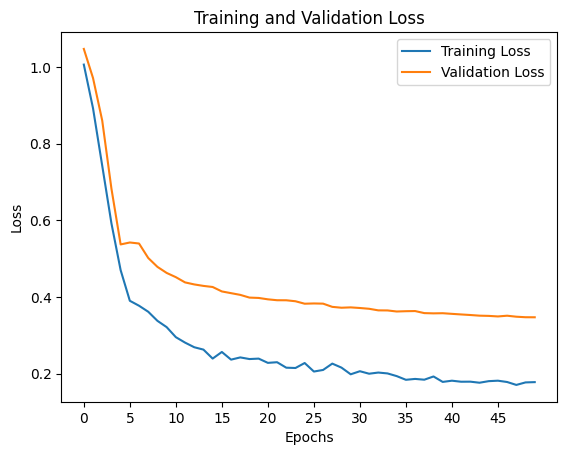

In [43]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [44]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 9.731391906738281
MSE Loss: 560.7460327148438
RMSE Loss: 23.680076599121094


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


## 3 steps (15 m)

In [45]:
steps = 3

### Seed 0

In [46]:
seed = 0
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS08_50epoch_3step_0seed.sav
Epoch 0, Train Loss: 0.8612, Val Loss: 0.6690
Epoch 1, Train Loss: 0.4908, Val Loss: 0.3403
Epoch 2, Train Loss: 0.3132, Val Loss: 0.2806
Epoch 3, Train Loss: 0.2770, Val Loss: 0.2590
Epoch 4, Train Loss: 0.2525, Val Loss: 0.2410
Epoch 5, Train Loss: 0.2396, Val Loss: 0.2248
Epoch 6, Train Loss: 0.2224, Val Loss: 0.2107
Epoch 7, Train Loss: 0.2090, Val Loss: 0.1988
Epoch 8, Train Loss: 0.1964, Val Loss: 0.1895
Epoch 9, Train Loss: 0.1903, Val Loss: 0.1823
Epoch 10, Train Loss: 0.1861, Val Loss: 0.1763
Epoch 11, Train Loss: 0.1844, Val Loss: 0.1714
Epoch 12, Train Loss: 0.1720, Val Loss: 0.1673
Epoch 13, Train Loss: 0.1695, Val Loss: 0.1638
Epoch 14, Train Loss: 0.1708, Val Loss: 0.1611
Epoch 15, Train Loss: 0.1676, Val Loss: 0.1585
Epoch 16, Train Loss: 0.1601, Val Loss: 0.1561
Epoch 17, Train Loss: 0.1611, Val Loss: 0.1543
Epoch 18, Train Loss: 0.1564, Val Loss: 0.1524
Epoch 19, Train Loss: 0.1556, Val Loss: 0.1506
Epoch 20, Train L

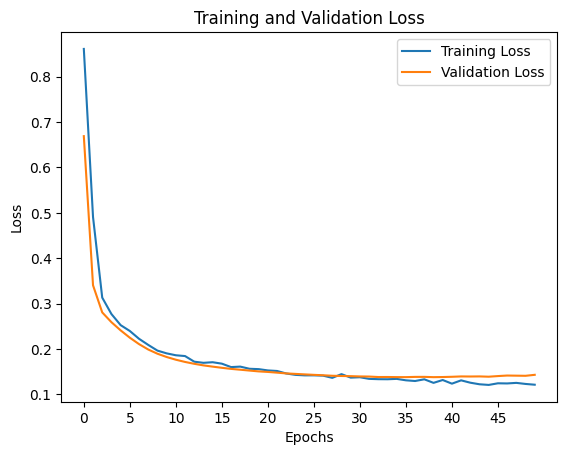

In [47]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [48]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 6.677835941314697
MSE Loss: 263.21533203125
RMSE Loss: 16.223913192749023


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


### Seed 42

In [49]:
seed = 42
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS08_50epoch_3step_42seed.sav
Epoch 0, Train Loss: 0.6941, Val Loss: 0.5053
Epoch 1, Train Loss: 0.4100, Val Loss: 0.3400
Epoch 2, Train Loss: 0.3193, Val Loss: 0.2884
Epoch 3, Train Loss: 0.2777, Val Loss: 0.2487
Epoch 4, Train Loss: 0.2399, Val Loss: 0.2196
Epoch 5, Train Loss: 0.2101, Val Loss: 0.1999
Epoch 6, Train Loss: 0.1971, Val Loss: 0.1859
Epoch 7, Train Loss: 0.1859, Val Loss: 0.1765
Epoch 8, Train Loss: 0.1812, Val Loss: 0.1696
Epoch 9, Train Loss: 0.1753, Val Loss: 0.1639
Epoch 10, Train Loss: 0.1723, Val Loss: 0.1596
Epoch 11, Train Loss: 0.1613, Val Loss: 0.1559
Epoch 12, Train Loss: 0.1654, Val Loss: 0.1529
Epoch 13, Train Loss: 0.1585, Val Loss: 0.1505
Epoch 14, Train Loss: 0.1561, Val Loss: 0.1487
Epoch 15, Train Loss: 0.1504, Val Loss: 0.1468
Epoch 16, Train Loss: 0.1508, Val Loss: 0.1454
Epoch 17, Train Loss: 0.1470, Val Loss: 0.1441
Epoch 18, Train Loss: 0.1445, Val Loss: 0.1435
Epoch 19, Train Loss: 0.1451, Val Loss: 0.1427
Epoch 20, Train 

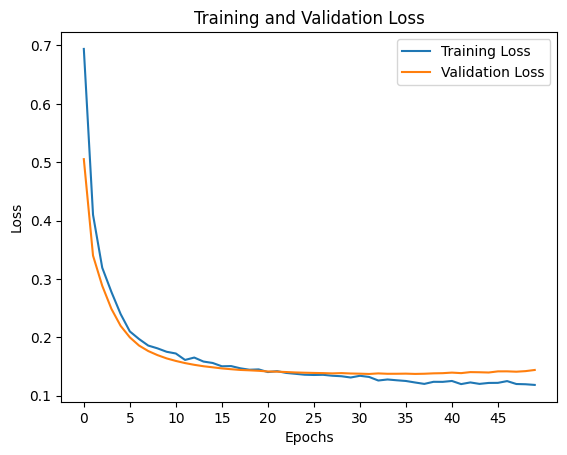

In [50]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [51]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 6.72646427154541
MSE Loss: 266.588134765625
RMSE Loss: 16.327526092529297


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


### Seed 1337

In [52]:
seed = 1337
edge_index, edge_attr, mean, std, *data = load_data(dataset_name, dir, seed, steps)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

save path: best_model_PEMS08_50epoch_3step_1337seed.sav
Epoch 0, Train Loss: 0.8709, Val Loss: 0.7022
Epoch 1, Train Loss: 0.5068, Val Loss: 0.3697
Epoch 2, Train Loss: 0.3430, Val Loss: 0.3195
Epoch 3, Train Loss: 0.2889, Val Loss: 0.2648
Epoch 4, Train Loss: 0.2428, Val Loss: 0.2321
Epoch 5, Train Loss: 0.2202, Val Loss: 0.2189
Epoch 6, Train Loss: 0.2084, Val Loss: 0.2084
Epoch 7, Train Loss: 0.2010, Val Loss: 0.2005
Epoch 8, Train Loss: 0.1968, Val Loss: 0.1937
Epoch 9, Train Loss: 0.1882, Val Loss: 0.1881
Epoch 10, Train Loss: 0.1811, Val Loss: 0.1831
Epoch 11, Train Loss: 0.1785, Val Loss: 0.1786
Epoch 12, Train Loss: 0.1715, Val Loss: 0.1746
Epoch 13, Train Loss: 0.1663, Val Loss: 0.1713
Epoch 14, Train Loss: 0.1668, Val Loss: 0.1683
Epoch 15, Train Loss: 0.1608, Val Loss: 0.1656
Epoch 16, Train Loss: 0.1604, Val Loss: 0.1632
Epoch 17, Train Loss: 0.1549, Val Loss: 0.1610
Epoch 18, Train Loss: 0.1557, Val Loss: 0.1590
Epoch 19, Train Loss: 0.1516, Val Loss: 0.1575
Epoch 20, Trai

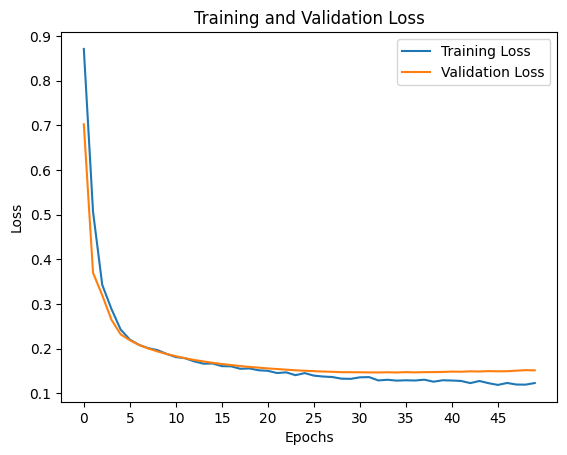

In [53]:
model, save_path = train(data, dataset_name, seed, steps, epochs, batch_size)

In [54]:
test_inputs = data[-2]
test_targets = data[-1]
evaluate(
    model, 
    save_path, 
    test_inputs, 
    test_targets, 
    batch_size, 
    edge_index, 
    edge_attr, 
    mean, 
    std,
)

MAE Loss: 6.844326972961426
MSE Loss: 274.0287170410156
RMSE Loss: 16.55381202697754


/tmp/ipykernel_23/3698104714.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))
